## X-Sectional Mean Reversion Strategy

Instead of looking at a mean reversion in the temporal dimension we will get a look to an index overperformers/underperformers. 

<i>Basicamente esta estrategia pretende comprar todos los activos que han tenido un retorno por debajo del del mercado y vender los que han tenido un retorno por encima del mercado, posicion rebalanceada cada dia al cierre. El peso de cada posicion en una accion en particular dependera de lo mucho que haya performeado un activo con respecto a la media del indice.</i>

## Retrieve the data

- Prices of each stock
- Constituents of the index

In [7]:
import pandas as pd
import numpy as np

In [8]:
close_price = pd.read_csv(r'/Users/educontreras/PycharmProjects/Quantitative-Finance/AlgoTrading_E_Chang/data/inputDataOHLCDaily_20120424_cl.csv')
open_price = pd.read_csv(r'/Users/educontreras/PycharmProjects/Quantitative-Finance/AlgoTrading_E_Chang/data/inputDataOHLCDaily_20120424_op.csv')
constituents =pd.read_csv(r'/Users/educontreras/PycharmProjects/Quantitative-Finance/AlgoTrading_E_Chang/data/inputDataOHLCDaily_20120424_stocks.csv')           

In [9]:
close_price['Var1']=pd.to_datetime(close_price['Var1'],  format='%Y%m%d').dt.date
open_price['Var1']=pd.to_datetime(open_price['Var1'],  format='%Y%m%d').dt.date
#We insert to constituents.values the element date
close_price.columns=np.insert(constituents.values, 0, "Date")
close_price.set_index("Date", drop = True, inplace = True)
close_price.index.name = None

open_price.columns=np.insert(constituents.values, 0, "Date")
open_price.set_index("Date", drop = True, inplace = True)
open_price.index.name = None

# Compute Market Returns

We will compute mean market returns to have the reference for each day. For this we have to compute the returns of each asset for every day and then the average return for all of them on a daily basis. 

In [10]:
individual_returns = close_price.pct_change()
market_returns = np.mean(individual_returns, axis = 1)

## What are going to be the weights on each asset?

Basically the most an asset over-underperform, the most weight in the asset. 

$$w_i = - \frac{r_i - R_M}{\sum_{k} \lvert{r_k - R_M}\rvert}$$

In [11]:
#We compute the numerator of the fraction
weights=-(np.array(individual_returns)-np.reshape(market_returns.values, (individual_returns.shape[0], 1)))

#The denominator of the fraction (sum of absolute values)
weights=weights/pd.DataFrame(np.abs(weights)).sum(axis=1).values.reshape((weights.shape[0], 1))


weights=pd.DataFrame(weights, columns=constituents.values[0], index=np.array(individual_returns.index))


## Compute returns on strategy

Basicall is: weights shifted by one day (markets weights determined on close are going to be applied on next business day)

In [42]:
dailyret=(weights.shift()*individual_returns).sum(axis=1) # Capital is always one
cumulated_returns = ((1+dailyret).cumprod()-1)
sharpe_ratio = np.sqrt(252)*np.mean(dailyret)/np.std(dailyret)
APR  =np.prod(1+dailyret)**(252/len(dailyret))-1

print('APR=%f Sharpe=%f' % (APR, sharpe_ratio))
# APR=13.7%, Sharpe=1.3

APR=0.111691 Sharpe=1.112433


<AxesSubplot:>

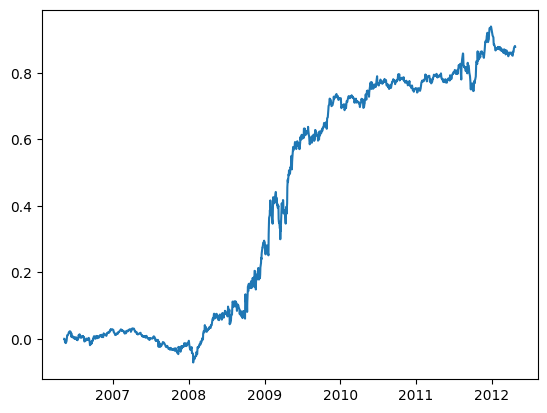

In [43]:
cumulated_returns.plot()

## Enhance the Strategy

We can enhance the strategy by determining our weights not based on close to close prices but on the close from last day to the open of the next one. What is the bad thing about the strategy? 

That we are not going to be able to trade at the openning price, so maybe we can use the first future contract on each constituent to establish the weightings per asset in the pre-opening


As we liquidate the position at the close --> We will trade two times per day. Lots of cost. 

<AxesSubplot:>

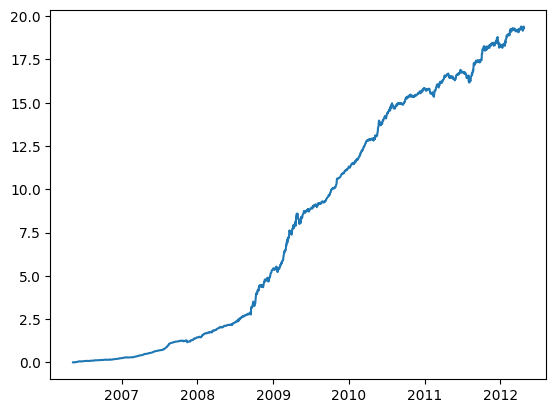

In [55]:

#Returns are (open - last day close)/last_day close 
individual_returns=(open_price-close_price.shift())/close_price.shift() # daily returns

#Now we look at the worst/best stocks previously to the open and the close
market_returns=np.mean(individual_returns, axis=1) # equal weighted market index return


#Same weighting scheme as before
weights=-(np.array(individual_returns)-np.reshape(market_returns.values, (individual_returns.shape[0], 1)))
weights=weights/pd.DataFrame(np.abs(weights)).sum(axis=1).values.reshape((weights.shape[0], 1))
weights=pd.DataFrame(weights, columns=constituents.values[0], index=np.array(individual_returns.index))

#We liquidate the position
dailyret=(weights*(close_price-open_price)/open_price).sum(axis=1) # Capital is always one

((1+dailyret).cumprod()-1).plot()
